In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('train.csv')

data.set_index('Id',inplace=True)

y = data.SalePrice
X_train = data.drop('SalePrice',axis=1)

In [2]:
import seaborn as sns
num_cols = list(X_train.select_dtypes(include=np.number).columns)
num_cols

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

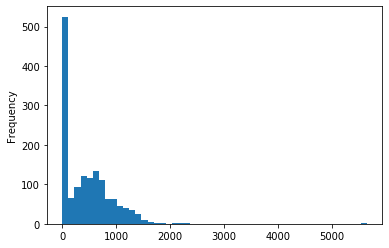

In [3]:
X_train['BsmtFinSF1'].plot(kind='hist',bins=50)
# np.log(X_train['GrLivArea']).plot(kind='hist',bins=50)

In [4]:
# #Write function to convert vars with lots of zeros to nans to impute later
# zero_val_cols = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
#              'TotalBsmtSF','2ndFlrSF','LowQualFinSF','GarageArea',
#             'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
#             'ScreenPorch',]

# #Convert zeros to NaN to impute down the line
# for col in zero_val_cols:
#     X_train[col] = X_train[col].apply(lambda x:np.nan if (x == 0) else x)

In [5]:
#Log transform certain columns
log_trans_cols = ['LotArea','1stFlrSF','GrLivArea']

for col in log_trans_cols:
    X_train[col] = np.log(X_train[col])

In [6]:
rank_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond',
                      'HeatingQC','KitchenQual','FireplaceQu','GarageQual',
                     'GarageCond',]

def rank_imputer(value):
    '''
    Convert cols with 5 ranks
    '''
    rank_map = {'ex':5,'gd':4,'ta':3,'fa':2,'po':1,np.nan:np.nan}
    try:
        return rank_map[value.lower()]
    except:
        return rank_map[value]

In [7]:
def bsmt_rank_imputer(value):
    '''
    Convert bsmtfintype columns
    '''
    rank_map = {'glq':6,'alq':5,'blq':4,
                'rec':3,'lwq':2,'unf':1,
                np.nan:np.nan}
    try:
        return rank_map[value.lower()]
    except:
        return rank_map[value]

In [8]:
bsmt_cols = ['BsmtFinType1','BsmtFinType2']
#Convert basement columns
for col in bsmt_cols:
    X_train[col] = X_train[col].apply(bsmt_rank_imputer)

In [9]:
#Convert 5 rank columns
for col in rank_cols:
    X_train[col] = X_train[col].apply(rank_imputer)

In [10]:
# from sklearn.preprocessing import OneHotEncoder

# #One-Hot Encode MSSubClass as values not ordinal
# MSSC_enc = OneHotEncoder(handle_unknown='ignore',sparse=False)

# MS_OH = pd.DataFrame(MSSC_enc.fit_transform(X_train[['MSSubClass']]))

# MS_OH.index = X_train.index
# X_train.drop('MSSubClass',axis=1,inplace=True)

# X_train = pd.concat([X_train, MS_OH], axis=1)

In [11]:
from sklearn.preprocessing import LabelEncoder

#Convert neighborhood column
lab_enc = LabelEncoder()
X_train['Neighborhood'] = lab_enc.fit_transform(X_train['Neighborhood'])

In [12]:
# #Find columns with greater than 90% missing values to drop entirely
# drop_cols = [col for col in X_train if 
#              X_train[col].isnull().sum()/len(X_train[col]) > 0.9]

# #Add miscval as useless without MiscFeature
# drop_cols.append('MiscVal')

# #Drop columns
# X_train.drop(drop_cols,axis=1,inplace=True)

In [13]:
# #Dropping the outlier rows with Percentiles
# upper_lim = X_train['LotArea'].quantile(.95)
# X_train.loc[(X_train['LotArea'] < upper_lim), 'LotArea'] = np.nan

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

cat_cols = [col for col in X_train.columns 
            if X_train[col].dtype == 'object' and
            X_train[col].nunique() <= 20]
num_cols = list(X_train.select_dtypes(include=np.number).columns)

my_cols = cat_cols + num_cols
X_train = X_train[my_cols].copy()

#Categorical Imputation
cat_imputer = Pipeline(steps = [
    ('imp',SimpleImputer(strategy='most_frequent')),
    ('OHE',OneHotEncoder(handle_unknown='ignore'))
])

#Numerical Imputation
num_imputer = SimpleImputer(strategy='mean')

#Bundled numerical and categorical transformer
transformer = ColumnTransformer(transformers = [
    ('num',num_imputer,num_cols),
    ('cat',cat_imputer,cat_cols)
])

X_train_xgb = pd.DataFrame(transformer.fit_transform(X_train))

In [15]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold

def get_cv_score(n_est,lr):
    #XGBoost Regressor (using n_estimators previously decided)
    my_model = XGBRegressor(n_estimators=n_est,learning_rate=lr)

    # CV model
    kfold = KFold(n_splits=5)
    results = -1 * cross_val_score(my_model, X_train_xgb, y, 
                              cv=kfold, scoring='neg_mean_absolute_error',
                                  verbose=False)
    #Mean Results
    return results.mean()

In [16]:
result = get_cv_score(550,0.06)
result

/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:59:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:59:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:59:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:59:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:00:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


15336.955161065925

In [17]:
# #Tries different n estimator values to find most accurate model
# nest_vals = [430,440,450,460]
# results = dict(zip(nest_vals, [get_cv_score(i,0.06) for i in nest_vals]))

In [18]:
# results

In [19]:
#XGBoost Regressor
final_model = XGBRegressor(n_estimators=450,learning_rate=0.06)
final_model.fit(X_train_xgb, y,verbose=False)

/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:00:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.06, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=450,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [20]:
#Load test data
test = pd.read_csv('test.csv')

test.set_index('Id',inplace=True)

#Convert 5 rank columns
for col in rank_cols:
    test[col] = test[col].apply(rank_imputer)

#Convert basement columns
for col in bsmt_cols:
    test[col] = test[col].apply(bsmt_rank_imputer)
    
#Convert neighborhood column
test['Neighborhood'] = lab_enc.transform(test['Neighborhood'])

#Log transform non-normal cols
for col in log_trans_cols:
    test[col] = np.log(test[col])

In [21]:
test = test[my_cols].copy()
test_xgb = pd.DataFrame(transformer.transform(test))

In [22]:
predictions = final_model.predict(test_xgb)

In [23]:
#Save final predictions for submission
submission10 = pd.DataFrame(predictions,index=test.index,columns=['SalePrice'])
submission10.to_csv(r'XGB_w_FE8.csv',index=True)

In [24]:
submission10.head()

,SalePrice
Id,
1461,120134.664062
1462,163351.093750
1463,176905.187500
1464,189799.187500
1465,187170.406250
